In [ ]:
!pip install biopython
from google.colab import drive
drive.mount('/content/drive')
from Bio import SeqIO
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import word2vec
from tabulate import tabulate
import logging
import random
vector_size = 100
klow = 4
khigh = 9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.3 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
def one_hot_encode_sequences(sequences):
    characters = 'ATCG'

    char_to_index = {char: i for i, char in enumerate(characters)}

    max_seq_length = max(len(seq) for seq in sequences)

    num_characters = len(characters)

    one_hot_matrix = np.zeros((len(sequences), max_seq_length, num_characters), dtype=int)

    for i, sequence in enumerate(sequences):
        for j, char in enumerate(sequence):
            if char in char_to_index:
                char_index = char_to_index[char]
                one_hot_matrix[i, j, char_index] = 1
            else :
                one_hot_matrix[i, j, 0] = 1

    return one_hot_matrix

In [ ]:
file_path = '/content/drive/MyDrive/ncbi_dataset/combined_without_monkeypox.csv'
df = pd.read_csv(file_path)

In [ ]:
df['1'] = df['1'].apply(lambda x: x[:20000])
label_encoder = LabelEncoder()
df['Disease_ID'] = label_encoder.fit_transform(df['0'])
# sequences = df['1'].apply(lambda seq: [1 if base == 'A' else 2 if base == 'T' else 3 if base == 'C' else 4 for base in seq])
# X = pad_sequences(sequences, padding='post', truncating='post')
sequences = df['1']
X_one_hot = one_hot_encode_sequences(sequences)

y = np.array(df['Disease_ID'])
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.3, random_state=42)
print(X_one_hot.shape)

(2741, 20000, 4)


In [ ]:
# Using l1 Regularization
model2 = Sequential()
model2.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2]), use_bias=True, kernel_regularizer=tf.keras.regularizers.l1( l=0.1)
))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, epochs=15, batch_size=32, validation_data = (X_test,y_test))

Epoch 1/30
43/60 [====================>.........] - ETA: 20s - loss: 4.7677 - accuracy: 0.8256

KeyboardInterrupt: ignored

In [ ]:
history_df = pd.DataFrame(history2.history)
history_df['epoch'] = history_df.index + 1  # Convert 'epoch' to integers
history_df['Epoch'] = history_df['epoch'].astype(int)
history_df[['Accuracy', 'Loss']] = history_df[['val_accuracy', 'val_loss']].round(5)  # Round off values

# Plot the table using Matplotlib
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed

columns = ['Epoch', 'Accuracy', 'Loss']
table_data = history_df[columns].values.tolist()

table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center', colColours=['#f5f5f5']*len(columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))

ax.axis('off')  # Turn off the axis

plt.show()

In [ ]:
del X_one_hot
del model2

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def read_csv_diseases(file_path):
    sequences = []

    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)

        next(csv_reader, None)

        for row in csv_reader:
            sequences.append(row[1])

    return sequences

def extract_kmers(sequence):
    seq_length = len(sequence)
    num_kmers = seq_length

    kmer_lengths = [random.randint(klow, khigh) for _ in range(num_kmers)]

    kmers = []

    for i, kmer_length in enumerate(kmer_lengths):
        if i + kmer_length <= seq_length:
            kmer = sequence[i:i + kmer_length]
            kmers.append(kmer)

    return kmers

def sequences_to_kmers(sequences):
    if klow < 1 or khigh < klow:
        raise ValueError("Invalid k-mer length values")

    kmer_dna_list = []

    for sequence in sequences:
        kmer_dna_list.append(extract_kmers(sequence))

    return kmer_dna_list

def dna2vec(sequences):
    kmer_sequences = sequences_to_kmers(sequences)



    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = word2vec.Word2Vec(kmer_sequences,min_count=1,vector_size=vector_size,sg=1,hs=0,window=5)
    model.save('dna2vec'+'.model')

    model = word2vec.Word2Vec.load('dna2vec'+'.model')

    mean = np.zeros((len(sequences), vector_size))
    for ii in range(len(sequences)):
        mean[ii] = np.sum(model.wv[kmer_sequences[ii]], axis = 0) / len(kmer_sequences[ii])

    return mean

In [ ]:
Y = np.zeros((df.shape[0], 1))
X_dna2vec = dna2vec(list(df["1"]))
for index, row in df.iterrows():
  Y[index] = row["0"]
  X_dna2vec[index] = X_dna2vec[index]
print(X_dna2vec.shape)
print(Y.shape)
Y = Y.reshape(df.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X_dna2vec, Y, test_size=0.3, random_state=421)

(2741, 100)
(2741, 1)


In [ ]:
# Using variable length kmers for training the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(vector_size, 1), use_bias=True, kernel_regularizer=tf.keras.regularizers.l1( l=0.1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow import keras
dot_img_file = '/model_1.png'
keras.utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 98, 32)            128       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 49, 32)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                100416    
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 100739 (393.51 KB)
Trainable params: 100739 (393.51 KB)
Non-trainable params: 0 (0.00 Byte)
______________

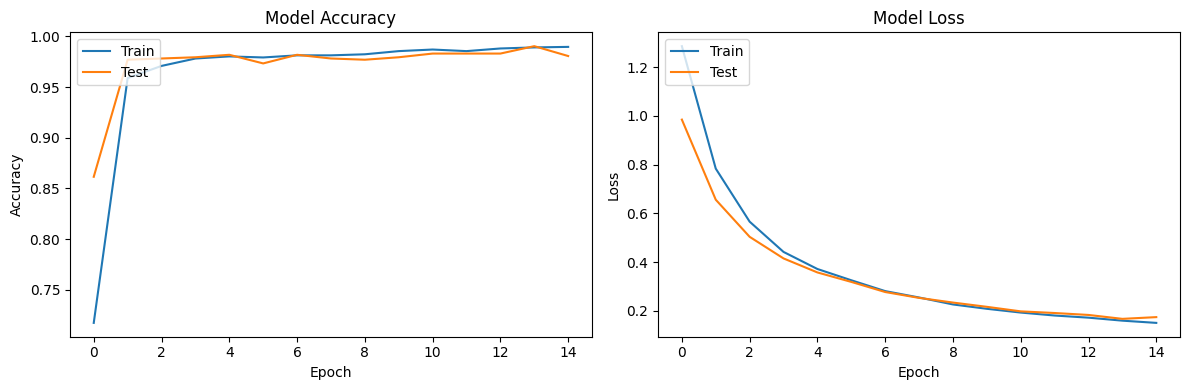

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
plt.style.use('seaborn-darkgrid')

# Plot the first set of graphs
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(history2.history['accuracy'], color='blue', label='Train')
plt.plot(history2.history['val_accuracy'], color='orange', label='Validation')
plt.title('Model Accuracy (One-hot Encoding)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history2.history['loss'], color='blue', label='Train')
plt.plot(history2.history['val_loss'], color='orange', label='Validation')
plt.title('Model Loss (One-hot Encoding)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Plot the second set of graphs
plt.subplot(2, 2, 3)
plt.plot(history.history['accuracy'], color='green', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Test')
plt.title('Model Accuracy (Dna2vec)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history.history['loss'], color='green', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Test')
plt.title('Model Loss (Dna2vec)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()